# Demos: Lecture 18

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm

## Exercise 1

Consider two qubits interacting under the Hamiltonian
  \begin{equation*}
    \hat{H} = -3 (Z_{0} + Z_{1}) + 2 Z_{0} Z_{1} + 4(X_{0} + X_{1})
  \end{equation*}
 
What is the energy of the system if the qubits are in state
  \begin{equation*}
    \ket{\psi} = \ket{+} \otimes \ket{0}
  \end{equation*}

In [2]:
coeffs = [-3, -3, 2, 4, 4]
obs = [qml.PauliZ(0), qml.PauliZ(1), qml.PauliZ(0) @ qml.PauliZ(1), qml.PauliX(0), qml.PauliX(1)]

In [3]:
H = qml.Hamiltonian(coeffs, obs)

In [4]:
print(H)

  (-3) [Z0]
+ (-3) [Z1]
+ (4) [X0]
+ (4) [X1]
+ (2) [Z0 Z1]


In [5]:
H_mat = qml.matrix(H)

In [6]:
H_mat

array([[-4.+0.j,  4.+0.j,  4.+0.j,  0.+0.j],
       [ 4.+0.j, -2.+0.j,  0.+0.j,  4.+0.j],
       [ 4.+0.j,  0.+0.j, -2.+0.j,  4.+0.j],
       [ 0.+0.j,  4.+0.j,  4.+0.j,  8.+0.j]])

In [7]:
np.linalg.eigvalsh(H_mat)

tensor([-9.56829032, -2.        ,  0.61040619, 10.95788413], requires_grad=True)

In [19]:
expm(-1j * 1 * H_mat)

array([[-0.0803559 -0.31847306j,  0.56075454-0.05709391j,
         0.56075454-0.05709391j, -0.40622293+0.3028036j ],
       [ 0.56075454-0.05709391j, -0.3111742 +0.4325405j ,
         0.10497264-0.47675692j, -0.04857985+0.39711149j],
       [ 0.56075454-0.05709391j,  0.10497264-0.47675692j,
        -0.3111742 +0.4325405j , -0.04857985+0.39711149j],
       [-0.40622293+0.3028036j , -0.04857985+0.39711149j,
        -0.04857985+0.39711149j,  0.07857173+0.64575871j]])

In [8]:
dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev)
def prepare_state():
    qml.Hadamard(wires=0)
    return qml.expval(H

In [9]:
prepare_state()

tensor(1., requires_grad=True)

## Demo 2: Time evolution

In [10]:
coeffs = [-2, -2]
obs = [qml.PauliZ(0), qml.PauliZ(1)]
H = qml.Hamiltonian(coeffs, obs)

In [11]:
dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev)
def version_1(t):
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.evolve(H, t)
    return qml.expval(qml.PauliX(wires=0))

In [12]:
t = np.linspace(0, 2, 100)
res = version_1(t)

/home/olivia/Software/anaconda3/envs/cpen400q/lib/python3.12/site-packages/pennylane/ops/op_math/exp.py:399: UserWarning: The autograd matrix for Evolution([0.-0.j         0.-0.02020202j 0.-0.04040404j 0.-0.06060606j
 0.-0.08080808j 0.-0.1010101j  0.-0.12121212j 0.-0.14141414j
 0.-0.16161616j 0.-0.18181818j 0.-0.2020202j  0.-0.22222222j
 0.-0.24242424j 0.-0.26262626j 0.-0.28282828j 0.-0.3030303j
 0.-0.32323232j 0.-0.34343434j 0.-0.36363636j 0.-0.38383838j
 0.-0.4040404j  0.-0.42424242j 0.-0.44444444j 0.-0.46464646j
 0.-0.48484848j 0.-0.50505051j 0.-0.52525253j 0.-0.54545455j
 0.-0.56565657j 0.-0.58585859j 0.-0.60606061j 0.-0.62626263j
 0.-0.64646465j 0.-0.66666667j 0.-0.68686869j 0.-0.70707071j
 0.-0.72727273j 0.-0.74747475j 0.-0.76767677j 0.-0.78787879j
 0.-0.80808081j 0.-0.82828283j 0.-0.84848485j 0.-0.86868687j
 0.-0.88888889j 0.-0.90909091j 0.-0.92929293j 0.-0.94949495j
 0.-0.96969697j 0.-0.98989899j 0.-1.01010101j 0.-1.03030303j
 0.-1.05050505j 0.-1.07070707j 0.-1.09090909j 0.-1.1

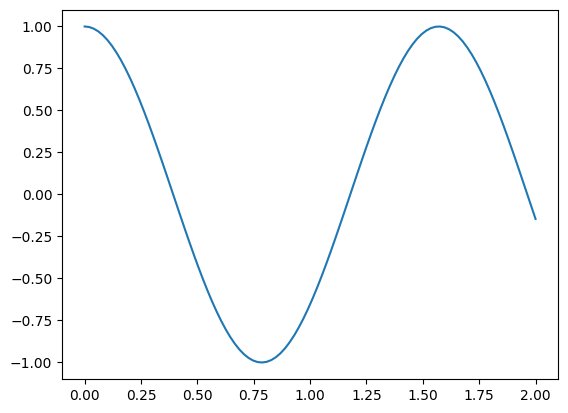

In [13]:
plt.plot(t, res)

In [14]:
@qml.qnode(dev)
def version_2(t):
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.RZ(2 * 2 * t, wires=0)
    qml.RZ(2 * 2 * t, wires=1)
    return qml.expval(qml.PauliX(wires=0))

t = np.linspace(0, 2, 100)
res = version_2(t)

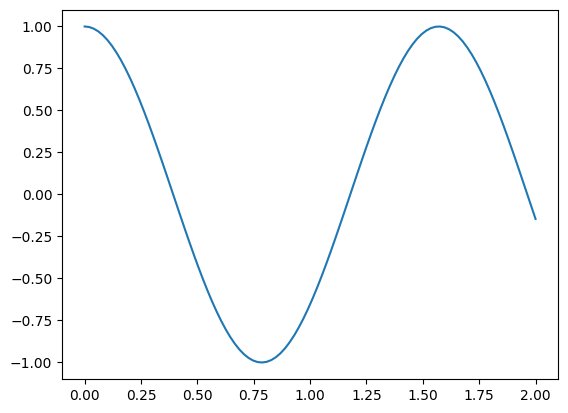

In [15]:
plt.plot(t, res)